# illustrates how to use `xr.align` to align target and potential predictors datasets, and look at regression fields 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr

### plotting 
from matplotlib import pyplot as plt
import cartopy
import cartopy.crs as ccrs

In [3]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [4]:
sys.path.append('/home/nicolasf/research/Smart_Ideas/code/')

In [5]:
from ml4seas import utils, GCM

xesmf is not installed, using method `interp_like` for interpolation


### selects a variable of interest 

In [6]:
var_name = 'RAIN'

### whether or not to remove the linear trend in the SST fields 

In [7]:
detrend = True 

### loads the dataset containing the targets for this variable: all 6 regions, seasonal anomalies and terciles + quintiles categories  

In [8]:
fname = f"NZ_6_regions_{var_name}_terciles_and_quintiles.nc"

In [9]:
data_path = HOME.joinpath(f"research/Smart_Ideas/outputs/targets/NZ_regions/NZ_6_regions/{var_name}").joinpath(fname)

In [10]:
dset_target = xr.open_dataset(data_path)

In [11]:
dset_target.info()

xarray.Dataset {
dimensions:
	region = 6 ;
	time = 490 ;

variables:
	datetime64[ns] time(time) ;
	float64 Rain_bc(region, time) ;
	int64 cat_3(region, time) ;
	float64 anomalies(region, time) ;
	object region(region) ;
	int64 cat_5(region, time) ;

// global attributes:
}

### now read some GCM outputs 

In [12]:
gcm_path = pathlib.Path('/media/nicolasf/END19101/data/GCMs/processed/CDS/ECMWF/SST') 

In [13]:
lfiles = list(gcm_path.glob("CDS_ECMWF_SST_*_seasonal_anomalies_1981_2010_clim.nc")) 

In [14]:
lfiles.sort()

In [15]:
dset_sst = xr.open_mfdataset(lfiles, concat_dim='init_time', combine='nested', parallel=True)

### the variable `init_time` corresponds to the initialisation time of the GCM, we rename it to `time` to make things easier for later alignment 

In [16]:
dset_sst.coords

Coordinates:
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat        (lat) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * member     (member) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * step       (step) int64 2 3 4 5
  * init_time  (init_time) datetime64[ns] 1981-01-01 1981-02-01 ... 2019-12-01
    month      (init_time) int64 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

In [17]:
dset_sst = dset_sst.rename({'init_time':'time'})

### We then shift the day in the time variable from corresponding to the beginning of the month to corresponding to the end of the month (`1981-01-01` becomes `1981-01-31`)

In [18]:
dset_sst = utils.shift_to_month_end(dset_sst)

In [19]:
dset_sst.time

<xarray.DataArray 'time' (time: 468)>
array(['1981-01-31T00:00:00.000000000', '1981-02-28T00:00:00.000000000',
       '1981-03-31T00:00:00.000000000', ..., '2019-10-31T00:00:00.000000000',
       '2019-11-30T00:00:00.000000000', '2019-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1981-01-31 1981-02-28 ... 2019-12-31
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

### we select step = 3, i.e. 3 months leadtime, i.e. for initial time of 1st of January (now recoded 31st January), we get the forecast valid for February - March - April (FMA) 1981

In [20]:
dset_sst = dset_sst.sel(step=3)

In [21]:
dset_sst.coords

Coordinates:
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * member   (member) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
    step     int64 3
  * time     (time) datetime64[ns] 1981-01-31 1981-02-28 ... 2019-12-31
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

### shifting of the time variable 

We now shift again the time variable, to change it from the initial time (shifted to end of month) to what the forecast data is valid for, so that the data 
for time=`1981-01-31`, holding the forecast for FMA 1981, end up being indexed by `1981-04-30`

In [22]:
dset_sst['time'] = dset_sst['time'].to_index().shift(periods=3, freq='M')

In [23]:
dset_sst.time[0]

<xarray.DataArray 'time' ()>
array('1981-04-30T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    step     int64 3
    time     datetime64[ns] 1981-04-30
    month    int64 1

### we can now align the datasets 

In [24]:
dset_sst, dset_target = xr.align(dset_sst, dset_target, join='inner', copy=False)

In [25]:
dset_sst.info()

xarray.Dataset {
dimensions:
	lat = 181 ;
	lon = 360 ;
	member = 25 ;
	time = 465 ;

variables:
	datetime64[ns] time(time) ;
	float32 lon(lon) ;
		lon:units = degrees_east ;
		lon:long_name = longitude ;
	float32 lat(lat) ;
		lat:units = degrees_north ;
		lat:long_name = latitude ;
	int32 member(member) ;
		member:long_name = ensemble_member ;
	int64 step() ;
	int64 month(time) ;
	float32 sst(time, member, lat, lon) ;

// global attributes:
}

In [26]:
dset_target.info()

xarray.Dataset {
dimensions:
	region = 6 ;
	time = 465 ;

variables:
	datetime64[ns] time(time) ;
	float64 Rain_bc(region, time) ;
	int64 cat_3(region, time) ;
	float64 anomalies(region, time) ;
	object region(region) ;
	int64 cat_5(region, time) ;

// global attributes:
}

### and we can merge the GCM data and the target, now that they are aligned along the common dimension (`time`) 

In [27]:
dset = xr.merge([dset_sst, dset_target])

In [28]:
dset.info()

xarray.Dataset {
dimensions:
	lat = 181 ;
	lon = 360 ;
	member = 25 ;
	region = 6 ;
	time = 465 ;

variables:
	datetime64[ns] time(time) ;
	float32 lon(lon) ;
		lon:units = degrees_east ;
		lon:long_name = longitude ;
	float32 lat(lat) ;
		lat:units = degrees_north ;
		lat:long_name = latitude ;
	int32 member(member) ;
		member:long_name = ensemble_member ;
	int64 step() ;
	int64 month(time) ;
	float32 sst(time, member, lat, lon) ;
	float64 Rain_bc(region, time) ;
	int64 cat_3(region, time) ;
	float64 anomalies(region, time) ;
	object region(region) ;
	int64 cat_5(region, time) ;

// global attributes:
}

### only keep the variables of interest 

In [29]:
dset = dset[['sst','anomalies']]

In [30]:
dset.info()

xarray.Dataset {
dimensions:
	lat = 181 ;
	lon = 360 ;
	member = 25 ;
	region = 6 ;
	time = 465 ;

variables:
	float32 sst(time, member, lat, lon) ;
	float64 anomalies(region, time) ;
	datetime64[ns] time(time) ;
	float32 lon(lon) ;
		lon:units = degrees_east ;
		lon:long_name = longitude ;
	float32 lat(lat) ;
		lat:units = degrees_north ;
		lat:long_name = latitude ;
	int32 member(member) ;
		member:long_name = ensemble_member ;
	int64 step() ;
	int64 month(time) ;
	object region(region) ;

// global attributes:
}

### we can now select a region 

In [31]:
dset = dset.sel(region='NNI')

### and calculates the ensemble mean 

In [32]:
dset.info()

xarray.Dataset {
dimensions:
	lat = 181 ;
	lon = 360 ;
	member = 25 ;
	time = 465 ;

variables:
	float32 sst(time, member, lat, lon) ;
	float64 anomalies(time) ;
	datetime64[ns] time(time) ;
	float32 lon(lon) ;
		lon:units = degrees_east ;
		lon:long_name = longitude ;
	float32 lat(lat) ;
		lat:units = degrees_north ;
		lat:long_name = latitude ;
	int32 member(member) ;
		member:long_name = ensemble_member ;
	int64 step() ;
	int64 month(time) ;
	<U3 region() ;

// global attributes:
}

### and calculate e.g. the ensemble mean 

In [33]:
dset = dset.mean('member')

In [34]:
dset.info()

xarray.Dataset {
dimensions:
	lat = 181 ;
	lon = 360 ;
	time = 465 ;

variables:
	float32 sst(time, lat, lon) ;
	float64 anomalies(time) ;
	datetime64[ns] time(time) ;
	float32 lon(lon) ;
		lon:units = degrees_east ;
		lon:long_name = longitude ;
	float32 lat(lat) ;
		lat:units = degrees_north ;
		lat:long_name = latitude ;
	int64 step() ;
	int64 month(time) ;
	<U3 region() ;

// global attributes:
}

### makes it easy to do something like linear regression 

### uses the xr_linregress function of [xarrayutils](https://github.com/jbusecke/xarrayutils)

In [35]:
from xarrayutils.utils import xr_linregress, xr_detrend

### check if the boolean variable `detrend` is set to True, detrend if so 

In [36]:
if detrend: 
    dset['sst'] = xr_detrend(dset['sst'])

In [37]:
regression_params = xr_linregress(dset['sst'], dset['anomalies'], dim='time')

In [38]:
regression_params.info()

xarray.Dataset {
dimensions:
	lat = 181 ;
	lon = 360 ;

variables:
	float32 lon(lon) ;
		lon:units = degrees_east ;
		lon:long_name = longitude ;
	float32 lat(lat) ;
		lat:units = degrees_north ;
		lat:long_name = latitude ;
	int64 step() ;
	<U3 region() ;
	float64 slope(lat, lon) ;
	float64 intercept(lat, lon) ;
	float64 r_value(lat, lon) ;
	float64 p_value(lat, lon) ;
	float64 std_err(lat, lon) ;

// global attributes:
}

### compute

In [39]:
regression_params.compute()

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.Dataset>
Dimensions:    (lat: 181, lon: 360)
Coordinates:
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat        (lat) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
    step       int64 3
    region     <U3 'NNI'
Data variables:
    slope      (lat, lon) float64 nan nan nan nan ... -1.972 -1.979 -1.98 -1.981
    intercept  (lat, lon) float64 nan nan nan nan ... -3.259 -3.259 -3.259
    r_value    (lat, lon) float64 nan nan nan nan ... -0.01492 -0.01493 -0.01494
    p_value    (lat, lon) float64 nan nan nan nan ... 0.7482 0.7482 0.7481 0.748
    std_err    (lat, lon) float64 nan nan nan nan nan ... 6.14 6.163 6.162 6.163

### and now plots 

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


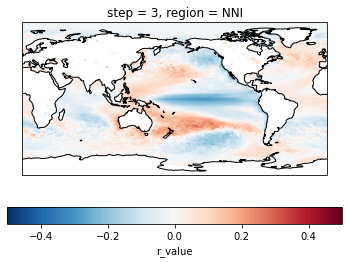

In [40]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
regression_params['r_value'].plot(vmin=-.5, vmax=.5, cmap='RdBu_r', transform=ccrs.PlateCarree(), cbar_kwargs={'orientation':'horizontal'})
ax.coastlines()

### Now do the same thing, but with observed SSTs 

In [41]:
ersst_path = pathlib.Path('/media/nicolasf/END19101/data/ERSST/processed/')

In [42]:
lfiles = list(ersst_path.glob("ERSST_seasonal_anomalies_*.nc")) 

In [43]:
lfiles.sort()

In [44]:
dset_ersst = xr.open_mfdataset(lfiles, concat_dim='time', combine='nested')

### keep 1981 onwards 

In [45]:
dset_ersst = dset_ersst.sel(time=slice('1981', None))

In [46]:
dset_ersst.info()

xarray.Dataset {
dimensions:
	lat = 89 ;
	lon = 180 ;
	time = 471 ;

variables:
	float64 lat(lat) ;
		lat:units = degrees_north ;
		lat:long_name = Latitude ;
		lat:standard_name = latitude ;
		lat:axis = Y ;
		lat:comment = Uniform grid from -88 to 88 by 2 ;
	float64 lon(lon) ;
		lon:units = degrees_east ;
		lon:long_name = Longitude ;
		lon:standard_name = longitude ;
		lon:axis = X ;
		lon:comment = Uniform grid from 0 to 358 by 2 ;
	datetime64[ns] time(time) ;
	int64 month(time) ;
	float32 sst(time, lat, lon) ;

// global attributes:
}

### shifting of the time variable 

for the observed SST, we need to shift the time variable so that the target variable for one particular season (let's say DJF 2010-2011, indexed with `2011-02-28`) is aligned with the observed SSTs **4 months before** (ASO 2010) so that it adequately reflects the availability of observed data for the prediction of a future target season 

#### before the shift, first time step is `1981-01-31` (corresponding to NDJ 1980-1981)

In [47]:
dset_ersst.time[0]

<xarray.DataArray 'time' ()>
array('1981-01-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1981-01-31
    month    int64 1

In [48]:
dset_ersst['time'] = dset_ersst['time'].to_index().shift(periods=4, freq='M')

#### after the shift

In [49]:
dset_ersst.time[0]

<xarray.DataArray 'time' ()>
array('1981-05-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1981-05-31
    month    int64 1

#### The data for NDJ 1980-1981 is now indexed by `1981-05-31`, i.e. will be aligned with the target variable for MAM 1981, that's what we want 

In [50]:
dset_ersst, dset_target = xr.align(dset_ersst, dset_target)

In [51]:
if detrend: 
    dset_ersst['sst'] = xr_detrend(dset_ersst['sst'])

In [52]:
dset_ersst

,Array,Chunk
Bytes,59.47 MB,128.16 kB
Shape,"(464, 89, 180)","(1, 89, 180)"
Count,14372 Tasks,464 Chunks
Type,float64,numpy.ndarray


### regression now, one can do it all 'at once' for all regions

In [53]:
regression_params = xr_linregress(dset_ersst['sst'], dset_target['anomalies'], dim='time')

In [54]:
regression_params.compute()

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, region: 6)
Coordinates:
  * lat        (lat) float64 -88.0 -86.0 -84.0 -82.0 ... 82.0 84.0 86.0 88.0
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * region     (region) object 'NNI' 'WNI' 'ENI' 'NSI' 'WSI' 'ESI'
Data variables:
    slope      (lat, lon, region) float64 nan nan nan nan ... 987.5 -858.0 549.6
    intercept  (region, lat, lon) float64 nan nan nan ... 0.8988 0.8988 0.8988
    r_value    (lat, lon, region) float64 nan nan nan ... -0.05915 0.1047
    p_value    (lat, lon, region) float64 nan nan nan ... 0.0955 0.2034 0.02407
    std_err    (lat, lon, region) float64 nan nan nan nan ... 591.2 673.6 242.8

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


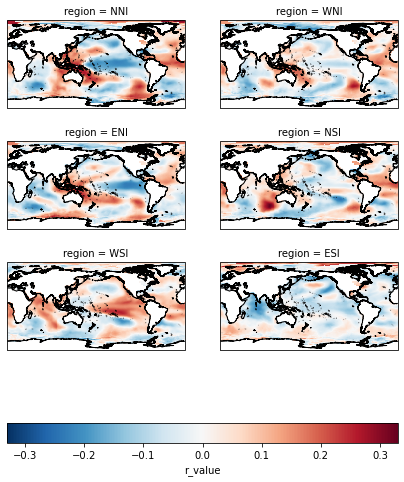

In [55]:
fg = regression_params['r_value'].plot(x='lon',
                                       y='lat',
                                       col='region',
                                       col_wrap=2,
                                       subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=180)), 
                                       transform=ccrs.PlateCarree(), 
                                       cbar_kwargs={'orientation':'horizontal'}) 
fg.map(lambda: plt.gca().coastlines(resolution='10m'))

### can also do the same per season

### DJF

In [56]:
regression_params = xr_linregress(
                    dset_ersst.sel(time=dset_ersst["time.month"] == 2)['sst'], 
                    dset_target.sel(time=dset_target["time.month"] == 2)['anomalies']
                    )

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


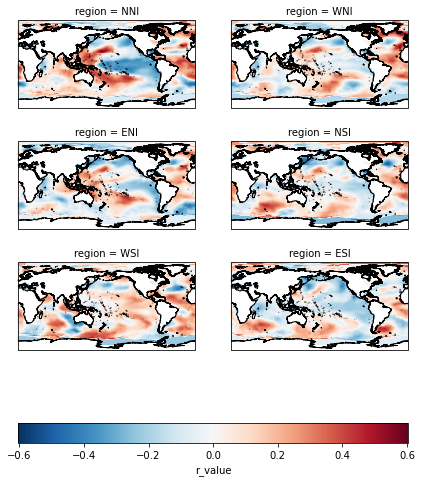

In [57]:
fg = regression_params['r_value'].plot(x='lon',
                                       y='lat',
                                       col='region',
                                       col_wrap=2,
                                       subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=180)), 
                                       transform=ccrs.PlateCarree(), 
                                       cbar_kwargs={'orientation':'horizontal'}) 
fg.map(lambda: plt.gca().coastlines(resolution='10m'))

### JJA 

In [58]:
regression_params = xr_linregress(
                    dset_ersst.sel(time=dset_ersst["time.month"] == 8)['sst'], 
                    dset_target.sel(time=dset_target["time.month"] == 8)['anomalies']
                    )

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


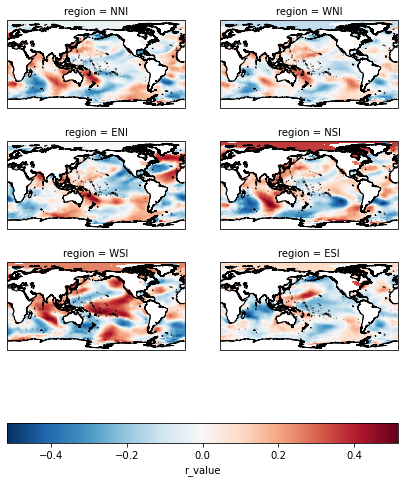

In [59]:
fg = regression_params['r_value'].plot(x='lon',
                                       y='lat',
                                       col='region',
                                       col_wrap=2,
                                       subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=180)), 
                                       transform=ccrs.PlateCarree(), 
                                       cbar_kwargs={'orientation':'horizontal'}) 
fg.map(lambda: plt.gca().coastlines(resolution='10m'))

### composite analysis 

In [60]:
region_name = 'NNI'

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


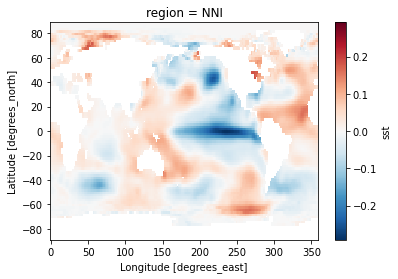

In [61]:
dset_ersst.sel(time=dset_target.sel(region=region_name)['cat_3'] == 3).mean('time')['sst'].plot()

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


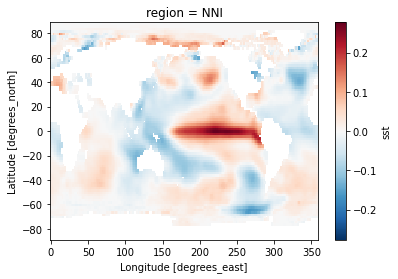

In [62]:
dset_ersst.sel(time=dset_target.sel(region=region_name)['cat_3'] == 1).mean('time')['sst'].plot()